## **RADI608: Data Mining and Machine Learning**

### Assignment: Applications of Machine Learning in Healthcare
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/RADI608/tree/main/Submitted)

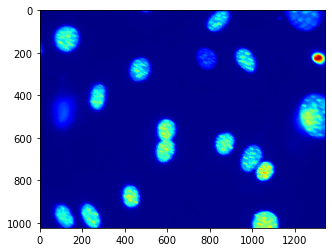

In [51]:
import numpy as np
import pylab
import mahotas as mh
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import SimpleITK as sitk
import os 
import random 
import cv2

dna = mpimg.imread('../data/dna.JPG')
plt.imshow(dna)
plt.show()

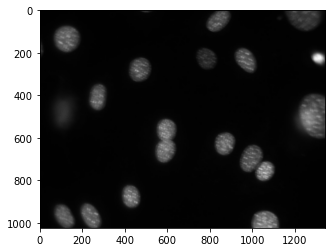

In [6]:
dna = mh.imread('../data/dna.jpg')
pylab.imshow(dna)
pylab.gray()
pylab.show()

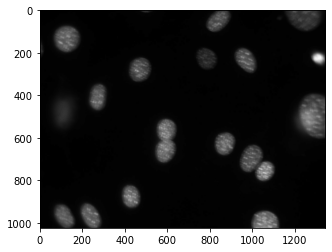

In [18]:
pylab.imshow(dna // 2)
pylab.show()

### Threshold the image and count the number of objects. 
The fact that <code>dna</code> is a numpy array and using it in logical operations is possible. The result is a numpy array og booleans which pylab shows as a black and white image (or red and blue if you have not previously called <code>pylab.gray()</code>)

45


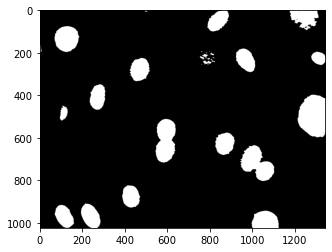

In [21]:
T = mh.thresholding.otsu(dna)
print(T)
pylab.imshow(dna > T)
pylab.show()

This image contains many small objects. We can count the number of objects by using a Gaussian filter. The function <code>mh.gaussian_filter</code> takes an image and the standard deviation of the filter (in pixel units) and returns the filtered image.

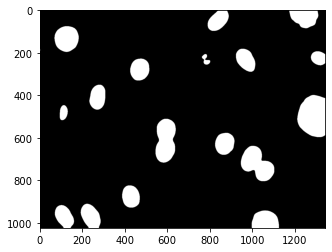

In [8]:
dnaf = mh.gaussian_filter(dna, sigma = 8) 
dnaf = dnaf.astype('uint8')
T = mh.thresholding.otsu(dnaf)
pylab.imshow(dnaf > T)
pylab.show()

The number of objects in the image =18. The <code>pylab.jet()</code> is for the resetting of colour map to jet (if we have the greyscale map active)


18


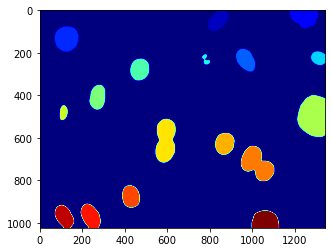

In [9]:
labeled,nr_objects = mh.label(dnaf > T)
print(nr_objects)
pylab.imshow(labeled)
pylab.jet()
pylab.show()

### Finding the seeds, sigma value = 16
<code>mh.overlay()</code> returns a colour image with the grey level component being given by its first argument while overlaying its second argument as a red channel.

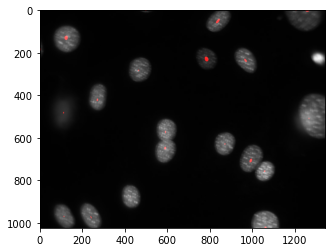

22


In [24]:
dnaf = mh.gaussian_filter(dna, sigma = 16)
dnaf = dnaf.astype('uint8')
rmax = mh.regmax(dnaf)
pylab.imshow(mh.overlay(dna, rmax))
pylab.show()


seeds,nr_objects = mh.label(rmax)
print(nr_objects)

### Apply watershed to the distance transform of the thresholded image
This is another technique based on the original dataset. We calculated the conditional distance between the <code>dnaf</code> and threshold T. The change of color givus us information. Different shades of color follows the position of the nucleus. 

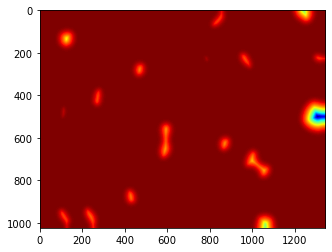

In [23]:
T = mh.thresholding.otsu(dnaf)
dist = mh.distance(dnaf > T)
dist = dist.max() -dist
dist -= dist.min()
dist = dist/float(dist.ptp()) * 255
dist = dist.astype(np.uint8)
pylab.imshow(dist)
pylab.jet()
pylab.show()

Each pixel gets assigned to the <code>nearest</code>.

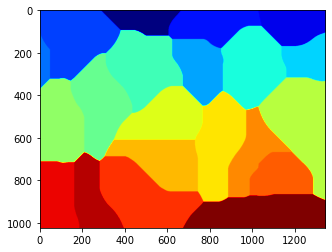

nuclei intheimage:  22


In [26]:
nuclei = mh.cwatershed(dist, seeds)
whole = mh.segmentation.gvoronoi(nuclei)
pylab.imshow(whole)
pylab.show()

print("nuclei intheimage: ", len(np.unique(whole)))

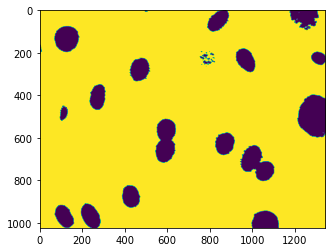

In [3]:
def bias_field_correction(inputImage):
    inputImage = sitk.Cast(inputImage, sitk.sitkFloat32)
    maskImage = sitk.OtsuThreshold(inputImage)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    correctedImage = corrector.Execute(inputImage, maskImage)
    log_bias_field = corrector.GetLogBiasFieldAsImage(inputImage)
    bias_field = inputImage / sitk.Exp(log_bias_field)
    return maskImage, correctedImage, log_bias_field

dna = sitk.ReadImage('../data/dna.jpg')
maskImage, correctedImage, log_bias_field = bias_field_correction(dna)

nda = sitk.GetArrayFromImage(maskImage)
plt.imshow(nda)

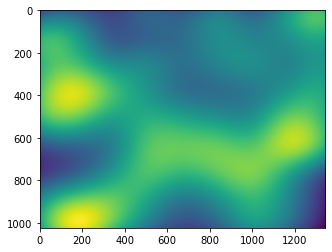

In [4]:
nda = sitk.GetArrayFromImage(log_bias_field)
plt.imshow(nda)

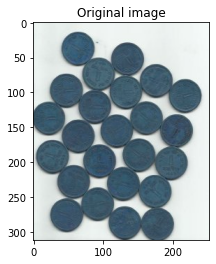

In [20]:
import cv2

img = cv2.imread('../data/water_coins.jpg')
plt.imshow(img)
plt.title('Original image')
plt.show()

We start with finding an approximate estimate of 
the coins. For that, we can use the Otsu’s 
binarization

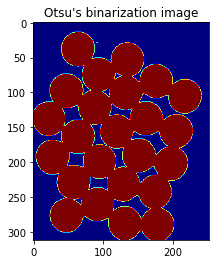

In [36]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# ret       ===> integer
# thresh    ===> image numpy array

plt.imshow(thresh)
plt.title('Otsu\'s binarization image')
plt.show()

### Noise Removal

We remove the small whote noises in the image by using a morphological opening. To remove any small holes in the object, we can use morphological closing. 

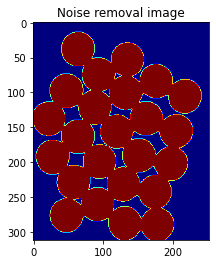

In [39]:
kernel = np.ones((3,3),np.uint8)
# Kernel Filter ====> kernel

opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
# cv2.MORPH_OPEN ===> Morphological Transformation like Erode, Dilate 
# opening ===> image array 
plt.imshow(opening)
plt.title('Noise removal image')
plt.show()

The region away from the object are background. 

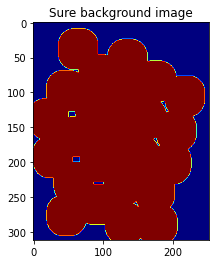

In [41]:
sure_bg = cv2.dilate(opening, kernel, iterations = 5)
plt.imshow(sure_bg)
plt.title('Sure background image')
plt.show()

### Finding sure foreground area


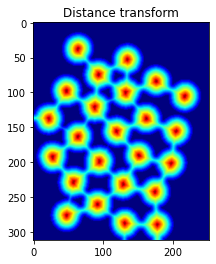

In [43]:
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2,5)
# cv2.DIST_L2 ===> distancing algorithm with L2 penalty

plt.imshow(dist_transform)
plt.title('Distance transform')
plt.show()

### Finding sure foreground area
- The region near to center of objects are 
foreground
- Only region we are not sure is the boundary 
region of coins

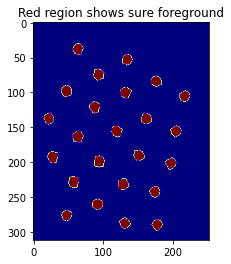

In [44]:
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
plt.imshow(sure_fg)
plt.title('Red region shows sure foreground')
plt.show()

### Find the unknown region by subtracting the sure background to the sure foreground

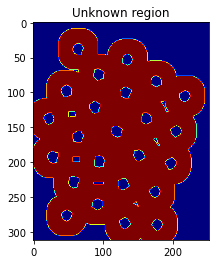

In [46]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown)
plt.title('Unknown region')
plt.show()


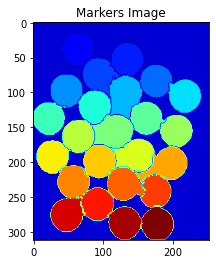

In [47]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0
markers = cv2.watershed(img,markers)
plt.imshow(markers)
plt.title('Markers Image')
plt.show()

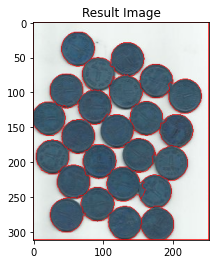

In [49]:
img[markers == -1] = [255,0,0]
plt.imshow(img)
plt.title('Result Image')
plt.show()

Image name = person1000_bacteria_2931.jpeg
The dimensions are 760 pixels height and 1152 pixels width
The maximum pixel value is 255.0000
The minimum pixel value is 0.0000
The mean value of the pixels is 114.5373
The standard deviation is 56.2341


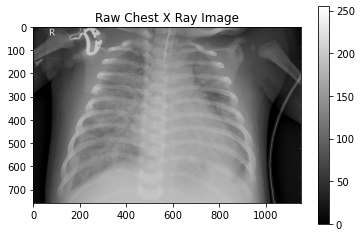

In [72]:
import os 
import cv2 as cv 

def load_image(path):
    for img in os.listdir(path):
        print('Image name =',img)
        image = cv.imread(os.path.join(path, img))
        break
    return image

bacteria_path = 'D:/chest_xray/chest_xray/train/PNEUMONIA/'
image = load_image(bacteria_path)
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions are {image.shape[0]} pixels height and {image.shape[1]} pixels width")
print(f"The maximum pixel value is {image.max():.4f}")
print(f"The minimum pixel value is {image.min():.4f}")
print(f"The mean value of the pixels is {image.mean():.4f}")
print(f"The standard deviation is {image.std():.4f}")

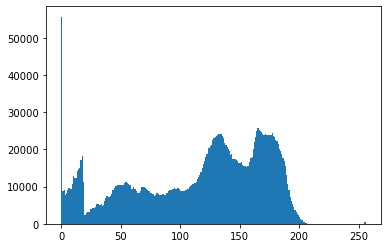

In [71]:
plt.hist(image.ravel(), 256, [0, 256]) 
plt.show()

In [94]:
path = 'D:/chest_xray/chest_xray/train/'
train = os.listdir(path)
folders=[]
folders = [f for f in sorted(os.listdir(path))]
print(folders)

folders=[]
folders = [f for f in sorted(os.listdir(path))]
print(folders)
labels = folders
print (f'The labels are {labels}')
# setting the size of images that we want
image_size = 256
print(f'All images to be resized into {image_size}*{image_size} pixels')

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
The labels are ['NORMAL', 'PNEUMONIA']
All images to be resized into 256*256 pixels


In [98]:
import warnings 
warnings.filterwarnings('ignore')

def load_train(path):
    images = []
    for label in labels:
        direc = os.path.join(path, label)
        class_num = labels.index(label)
        for image in os.listdir(direc):
            image_read = cv.imread(os.path.join(direc,image),cv.IMREAD_GRAYSCALE)
            image_resized = cv.resize(image_read,(image_size,image_size))
            images.append([image_resized,class_num])
    return np.array(images)

#load all the training images to train_images
train_images = load_train(path)
print(f'Shape of the training images = {train_images.shape}')


Shape of the training images = (5216, 2)


In [100]:
X = []
y = []

for feature, label in train_images:
    X.append(feature)
    y.append(label)
print (f'Length of X = {len(X)}')
print (f'Length of y = {len(y)}') 

Length of X = 5216
Length of y = 5216


Numberof Normal images = 1341
Numberof Bacteria images = 3875


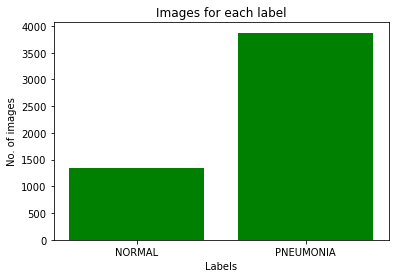

In [101]:
# checking the number of images of each class
a = 0
b = 0
for label in y:
    if label == 0:
        a += 1
    if label == 1:
        b += 1
print (f'Numberof Normal images = {a}')
print (f'Numberof Bacteria images = {b}')
# plotting the data
x_pos = [i for i, _ in enumerate(labels)]
numbers = [a,b]
plt.bar(x_pos,numbers,color = 'green')
plt.xlabel("Labels")
plt.ylabel("No. of images")
plt.title("Images for each label")
plt.xticks(x_pos, labels)
plt.show()


Display Random Images


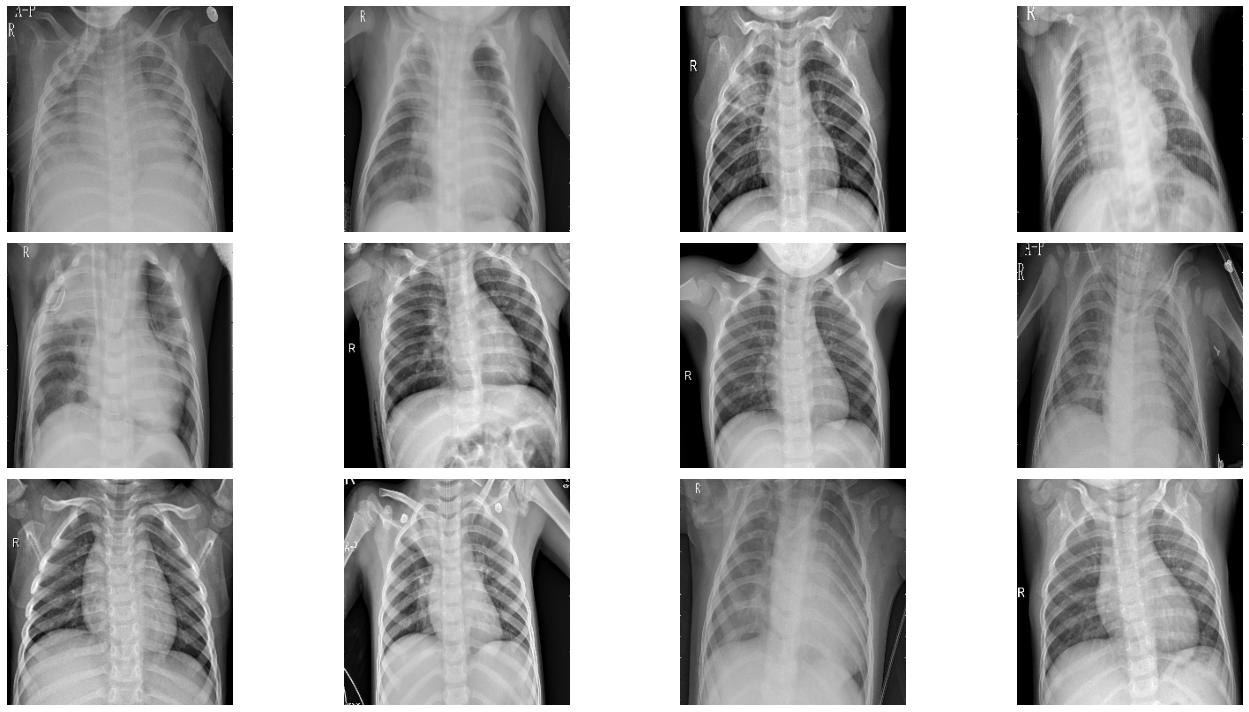

In [102]:
print('Display Random Images')
# Adjust the size of your images
plt.figure(figsize = (20,10))
for i in range(12):
    num = random.randint(0, len(X)-1)
    plt.subplot(3, 4, i + 1)
    plt.imshow(X[num],cmap='gray')
    plt.axis('off')
plt.tight_layout()

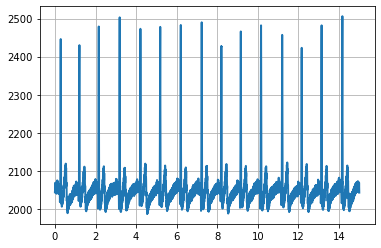

In [105]:
import numpy as np
import pylab as pl
from biosppy import storage

signal, mdata = storage.load_txt('../data/ecg.txt')
Fs = mdata['sampling_rate']
N = len(signal) #numberof samples
T = (N -1) /Fs #duration
ts = np.linspace(0,T, N,endpoint=False)
pl.plot(ts, signal, lw=2)
pl.grid()
pl.show()

KeyboardInterrupt: 

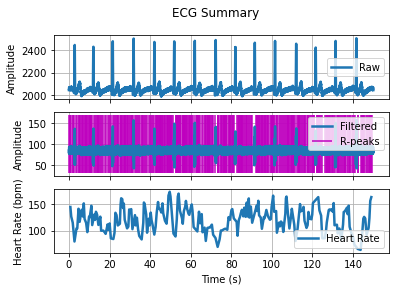

In [110]:
from biosppy.signals import ecg
out = ecg.ecg(signal=signal, sampling_rate = 100, show = True)


<AxesSubplot:>

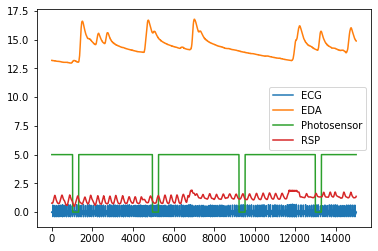

In [111]:
import numpy as np
import pandas as pd

df = pd.read_csv('../data/bio_100Hz.csv')
df.plot()

Automatically created module for IPython interactive environment
Using default location ~/mne_data for bst_raw...


100%|########################################| 532M/532M [00:00<00:00, 537GB/s]
Untarring contents of 'C:\Users\Renan\mne_data\bst_raw.tar.gz' to 'C:\Users\Renan\mne_data\MNE-brainstorm-data'


Attempting to create new mne-python configuration file:
C:\Users\Renan\.mne\mne-python.json
ds directory : C:\Users\Renan\mne_data\MNE-brainstorm-data\bst_raw\MEG\bst_raw\subj001_somatosensory_20111109_01_AUX-f.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
       0.84   69.49    0.00 mm <->    0.84   69.49   -0.00 mm (orig :  -44.30   51.45 -252.43 mm) diff =    0.000 mm
      -0.84  -69.49    0.00 mm <->   -0.84  -69.49    0.00 mm (orig :   46.28  -53.58 -243.47 mm) diff =    0.000 mm
      86.41    0.00    0.00 mm <->   86.41    0.00    0.00 mm (orig :   63.60   55.82 -230.26 mm) diff =    0.000 mm
    Coordinate transformations established.
    Reading digitizer points from ['C:\\Users\\Renan\\mne_data\\MNE-brainstorm-data\\bst_raw\\MEG\\bst_raw\\subj001_somatosensory_20111109_01_AUX-f.ds\\subj00111092011.pos']...
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 

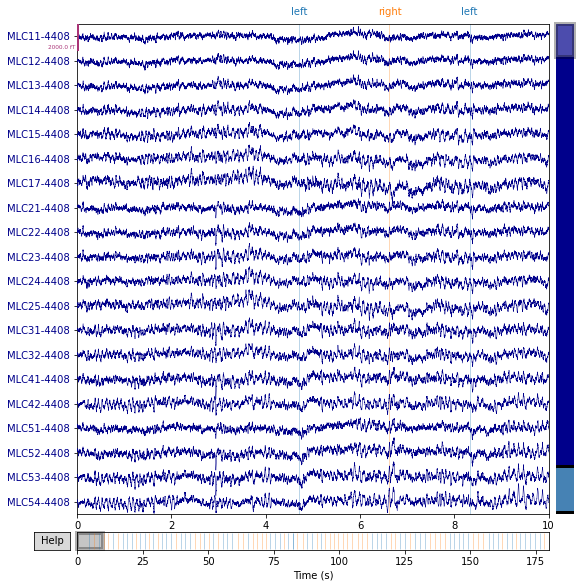

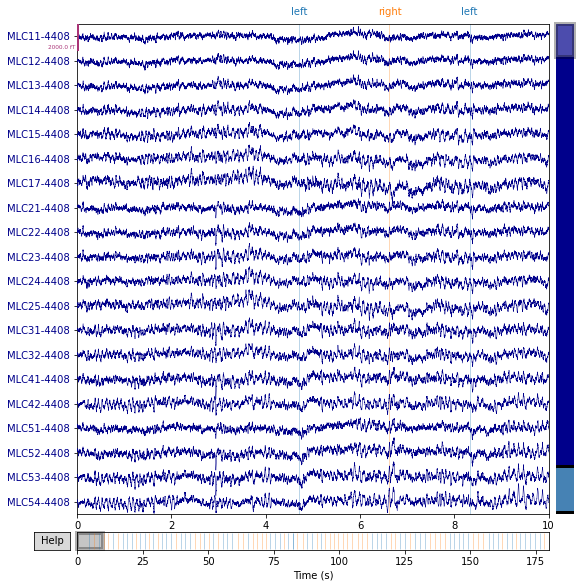

In [116]:
import mne
from mne.datasets.brainstorm import bst_raw
from mne.io import read_raw_ctf

print(__doc__)
tmin, tmax, event_id = -0.1, 0.3, 2 # take right-hand somato
reject = dict(mag=4e-12, eog=250e-6)
data_path = bst_raw.data_path()
raw_path = (data_path + '/MEG/bst_raw/' + 'subj001_somatosensory_20111109_01_AUX-f.ds')
# Here we crop to half the length to save memory
raw = read_raw_ctf(raw_path).crop(0, 180).load_data()
raw.plot()


Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Effective window size : 1.707 (s)
Effective window size : 1.707 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


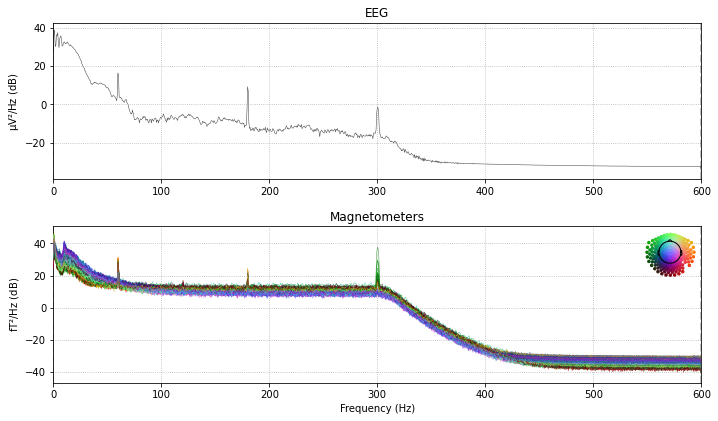

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 7921 samples (6.601 sec)

98 events found
Event IDs: [1 2]


In [117]:
# set EOG channel
raw.set_channel_types({'EEG058': 'eog'})
raw.set_eeg_reference('average', projection=True)
# show power line interference and remove it
raw.plot_psd(tmax=60., average=False)
raw.notch_filter(np.arange(60, 181, 60), fir_design='firwin')
events = mne.find_events(raw, stim_channel='UPPT001')


In [118]:
# pick MEG channels
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False, eog=True,
exclude='bads')
# Compute epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks, baseline=(None, 0), reject=reject, preload=False)
# compute evoked
evoked = epochs.average()
# remove physiological artifacts (eyeblinks, heartbeats) using SSP on baseline
evoked.add_proj(mne.compute_proj_evoked(evoked.copy().crop(tmax=0)))
evoked.apply_proj()
# fix stim artifact
mne.preprocessing.fix_stim_artifact(evoked)


Not setting metadata
Not setting metadata
53 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
1 projection items activated
    Rejecting  epoch based on EOG : ['EEG058']
    Rejecting  epoch based on EOG : ['EEG058']
Removing projector <Projection | Average EEG reference, active : True, n_channels : 1>
No gradiometers found. Forcing n_grad to 0
No EEG channels found. Forcing n_eeg to 0
Adding projection: axial--0.100-0.000-PCA-01
Adding projection: axial--0.100-0.000-PCA-02
2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...


<Evoked | '2' (average, N=51), -0.1 – 0.3 sec, baseline -0.1 – 0 sec, 298 ch, ~1.7 MB>

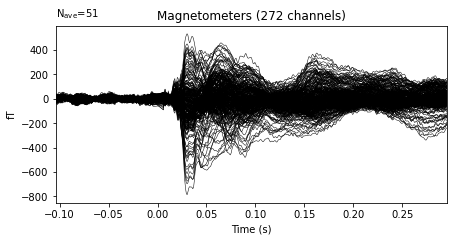

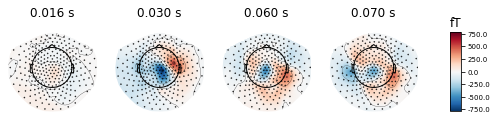

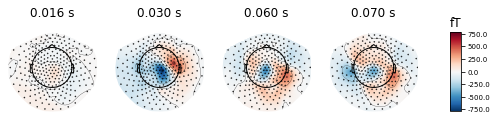

In [119]:
evoked.shift_time(-0.004)
evoked.plot(time_unit='s')
evoked.plot_topomap(times=np.array([0.016, 0.030, 0.060, 0.070]), time_unit='s')